# SIR Model for Omicron in Iran

## Import data, handle missing values, create a clean dataframe

In [251]:
import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import time

ic = pd.read_excel("D:\DS\Mine\Corona\I22-02-26.xlsx", index_col=0, parse_dates=[0])
ic['total_vaccinations_f'] = ic['total_vaccinations'].interpolate(method='linear').fillna(0)
ic['stringency_index_f'] = ic['stringency_index'].fillna(method="ffill")
icf = ic.loc[ : , ['total_cases', 'new_cases', 'new_cases_smoothed',
                   'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_vaccinations_f', 'stringency_index_f']]
icf = icf.asfreq(None)
pd.options.display.float_format = '{:,.2f}'.format
# pd.set_option('display.max_rows', 2000)
icf

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_vaccinations_f,stringency_index_f
date,,,,,,,,
2020-02-19,2,2,NaN,2,2,NaN,0.00,0.00
2020-02-20,5,3,NaN,2,0,NaN,0.00,2.78
2020-02-21,18,13,NaN,4,2,NaN,0.00,2.78
2020-02-22,28,10,NaN,5,1,NaN,0.00,11.11
2020-02-23,43,15,NaN,8,3,NaN,0.00,11.11
...,...,...,...,...,...,...,...,...
2022-02-21,6961562,19110,"18,048.71",135276,236,198.57,"139,778,863.00",62.04
2022-02-22,6983635,22073,"17,625.71",135499,223,206.57,"140,067,676.00",62.04
2022-02-23,6998975,15340,"17,487.14",135726,227,212.57,"140,520,797.00",62.04


<AxesSubplot:xlabel='date'>

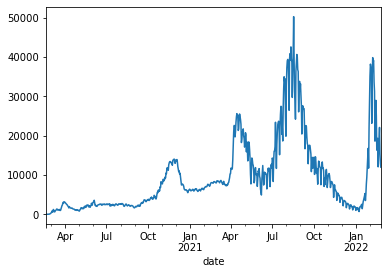

In [252]:
icf.loc[: , 'new_cases'].plot()

<AxesSubplot:xlabel='date'>

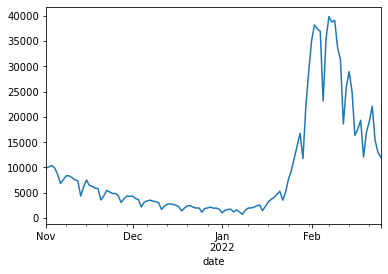

In [253]:
icf.loc['2021-11-01': , 'new_cases'].plot()

The start of Omicron in Iran is considered to be about 2022-01-15.

In [254]:
start_date = '2022-01-15' # The start of omicron in Iran, based on the graphs above and the news
icc = icf.loc[start_date: , 'new_cases_smoothed'] # Iran Corona Cases
icd = icf.loc[start_date: , 'total_deaths'] # Iran Corona Deaths
icd -= icd.iloc[0] # To start the cumulative deaths from zero, as we study Omicron only

## Defining the training data and observing them 

In [255]:
xtc = icc.values
xtd = icd.values

1973.714
Infected people


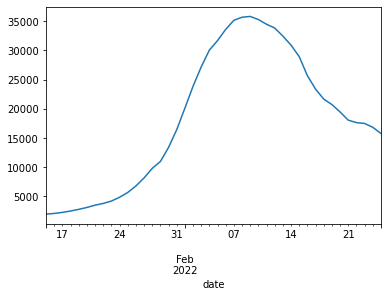

In [256]:
print(icc[0])
icc.plot()
print('Infected people')

Cumulative deaths from the beginning of Omicron


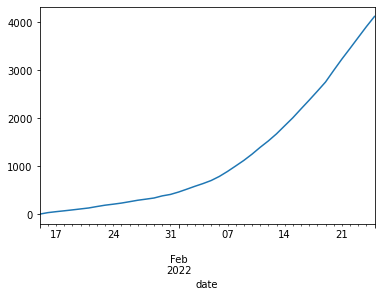

In [257]:
icd.plot()
print('Cumulative deaths from the beginning of Omicron')

## Definition of the basic SIR model

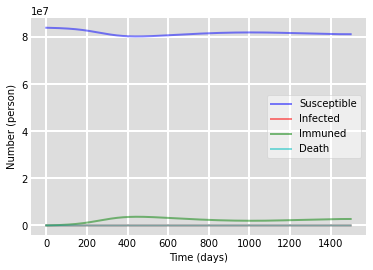

In [258]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

    # The SIR model differential equations.
def derivs(y, t, N, beta, epsilon, gamma, nu, delta):
    S, E, I, R, D = y
    dSdt = -beta * S * I / N + delta * R
    dEdt = beta * S * I / N - epsilon * E
    dIdt = epsilon * E - gamma * I - nu * I
    dRdt = gamma * I - delta * R
    dDdt = nu * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

    # Main
    # Initial conditions vector
    # Total population, N.
N = 84 * 10 ** 6
    # Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = icc.iloc[0], 1 #6.5 * 10 ** 6
E0 = I0
    # Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
BR = 1.013 ** (1 / 365)
D0 = 0 # Only for Omicron

    # Rates per day
    # beta: Contact rate, beta
beta = 0.9

    #epsilon: the rate at which exposed people are going to be infected
epsilon = 0.88
    # gamma: Recovery/removing rate, gamma
gamma = 0.873
    # nu: Deaths occuring out of daily removed people
nu = 0.0001
    # delta: rate of loss of immunity in entire removed (immuned) people
delta = 0.003

    # A grid of time points (in days)
t = np.linspace(0, 1499, 1500)
y0 = S0, E0, I0, R0, D0

    # Integrate the SIR equations over the time grid, t.
ret = odeint(derivs, y0, t, args=(N, beta, epsilon, gamma, nu, delta))
S, E, I, R, D = ret.T

    # Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Immuned')
ax.plot(t, D, 'c', alpha=0.5, lw=2, label='Death')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Number (person)')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## The optimization of the SIR model parameters

In [259]:
days = list(range(len(xtc)))
print(days)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]


In [291]:
# The error for prediction function
from sklearn.metrics import mean_squared_error
def error_for_ID(x):
    ebeta, eepsilon, egamma, enu, edelta = x[0], x[1], 0.2 * x[0], x[3], x[4]
    res = odeint(derivs, y0, days, args=(N, ebeta, eepsilon, egamma, enu, edelta))
    S, E, I, R, D = res.T
    err = mean_squared_error(I, xtc, sample_weight=days) / x[5] + mean_squared_error(D, xtd, sample_weight=days)
    return err 

In [293]:
from scipy.optimize import minimize
param_bounds = ((0.0000001, 90), (0.0000001, None), (0.0000001, None), (0.0000001, None), (0.03, 0.6), (10, 5000))
cons = ()#{'type': 'ineq', 'fun': lambda x:  x[0] - 2*x[2]})#, {'type': 'ineq', 'fun': lambda x:  5*x[2] - x[0]})
pzero = [0.8, 0.6, 0.2, 0.000001, 0.05, 100]
res = minimize(error_for_ID, x0=pzero, bounds=param_bounds, constraints=cons, callback=plot_in_progress)
print(res)
ox = res.x # Optimized X
ox[2] = 0.2 * ox[0]

84000000
[8.000000e-01 6.000000e-01 2.000000e-01 1.000001e+00 5.000000e-02
 1.000000e+02]
84000000
[7.71613891e-01 5.99852990e-01 2.00000000e-01 1.02748747e+00
 5.56877917e-02 9.99999890e+01]
84000000
[7.04914723e-01 5.99518945e-01 2.00000000e-01 1.08570167e+00
 6.57137502e-02 9.99999895e+01]
84000000
[6.20517087e-01 6.00075342e-01 2.00000000e-01 1.14857220e+00
 7.27048671e-02 1.00000042e+02]
84000000
[5.15944800e-01 5.99938745e-01 2.00000000e-01 1.21461713e+00
 7.51884280e-02 1.00000203e+02]
84000000
[3.79080629e-01 6.00461554e-01 2.00000000e-01 1.28535214e+00
 7.01782719e-02 1.00000613e+02]
84000000
[2.03800374e-01 5.98891659e-01 2.00000000e-01 1.35343108e+00
 5.20547678e-02 1.00001554e+02]
84000000
[1.00000000e-07 5.93824279e-01 2.00000000e-01 1.40531817e+00
 3.00000000e-02 1.00003536e+02]
84000000
[1.00000000e-07 1.00000000e-07 2.00000000e-01 1.32208830e+00
 3.00000000e-02 1.00194259e+02]
84000000
[1.00000000e-07 6.11010922e-03 2.00000000e-01 1.32349851e+00
 3.00000000e-02 1.001923

In [294]:
obeta, oepsilon, ogamma, onu, odelta = ox[0], ox[1], ox[2], ox[3], ox[4]

## Solving equation using the optimized SIR parameters

In [295]:
ret = odeint(derivs, y0, days, args=(N, obeta, oepsilon, ogamma, onu, odelta))
S, E, I, R, D = ret.T

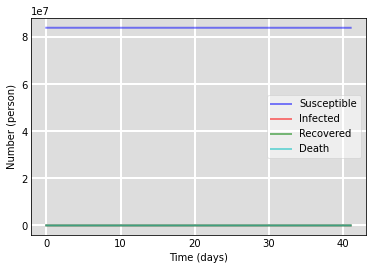

In [296]:
    # Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(days, S, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(days, I, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(days, R, 'g', alpha=0.5, lw=2, label='Recovered')
ax.plot(days, D, 'c', alpha=0.5, lw=2, label='Death')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Number (person)')
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
plt.show()

In [297]:

time.sleep(0.001)

TypeError: plot2() missing 4 required positional arguments: 'ax', 'x', 'y0', and 'y1'

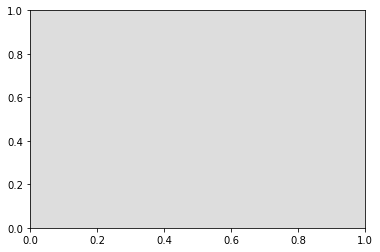

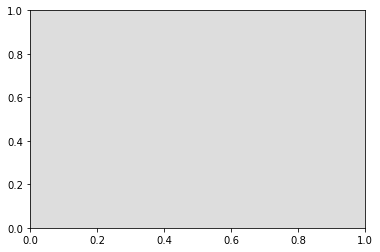

In [298]:
fig = plt.figure(facecolor='w')
fig1 = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax1 = fig1.add_subplot(111, facecolor='#dddddd', axisbelow=True)

plot2()

In [299]:
def plot2(ax, x, y0, y1, col0='g', col1='r', xlab='Days', ylab='Person', y0_lab='Main', y1_lab='Model'):
    ax.plot(x, y0, col0, alpha=0.5, lw=2, label=y0_lab)
    ax.plot(x, y1, col1, alpha=0.5, lw=2, label=y1_lab)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()

In [300]:
def plot_in_progress(ox):
    print(N)
    print(ox)
    obeta, oepsilon, ogamma, onu, odelta = ox[0], ox[1], ox[2], ox[3], ox[4]
    ret = odeint(derivs, y0, days, args=(N, obeta, oepsilon, ogamma, onu, odelta))
    S, E, I, R, D = ret.T


    plot2(ax, days, xtc, I, y0_lab='Infected')
    
    plot2(ax1, days, xtd, D, y0_lab='Deaths')

    t = np.linspace(0, 199, 200)
    ret = odeint(derivs, y0, t, args=(N, obeta, oepsilon, ogamma, onu, odelta))
    S, E, I, R, D = ret.T

#     fig = plt.figure(facecolor='w')
#     ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
#     plot2(ax, t, xtd, D, y0_lab='Deaths')

#     fig = plt.figure(facecolor='w')
#     ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
#     ax.plot(t,  I, 'r', alpha=0.5, lw=2, label='Model for new cases')
#     ax.plot(days, xtc, 'g', alpha=0.5, lw=2, label='Actual new cases')
#     ax.set_xlabel('Time (days)')
#     ax.set_ylabel('Number (person)')
#     ax.yaxis.set_tick_params(length=0)
#     ax.xaxis.set_tick_params(length=0)
#     ax.grid(b=True, which='major', c='w', lw=2, ls='-')
#     legend = ax.legend()
#     legend.get_frame().set_alpha(0.5)
#     for spine in ('top', 'right', 'bottom', 'left'):
#         ax.spines[spine].set_visible(False)
#     plt.show()

#     fig = plt.figure(facecolor='w')
#     ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
#     ax.plot(t[1:],  np.diff(D), 'r', alpha=0.5, lw=2, label='Model for daily deaths')
#     ax.plot(days, icf.loc[start_date: , 'new_deaths_smoothed'].values, 'b', alpha=0.5, lw=2, label='Actual daily deaths')
#     ax.set_xlabel('Time (days)')
#     ax.set_ylabel('Number (person)')
#     ax.yaxis.set_tick_params(length=0)
#     ax.xaxis.set_tick_params(length=0)
#     ax.grid(b=True, which='major', c='w', lw=2, ls='-')
#     legend = ax.legend()
#     legend.get_frame().set_alpha(0.5)
#     for spine in ('top', 'right', 'bottom', 'left'):
#         ax.spines[spine].set_visible(False)
#     plt.show()
    

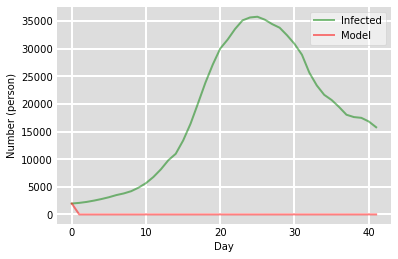

In [301]:
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(days, xtc, 'g', alpha=0.5, lw=2, label='Infected')
ax.plot(days, I, 'r', alpha=0.5, lw=2, label='Model')
ax.set_xlabel('Day')
ax.set_ylabel('Number (person)')

ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

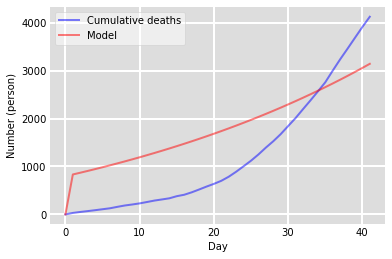

In [302]:
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(days, xtd, 'b', alpha=0.5, lw=2, label='Cumulative deaths')
ax.plot(days, D, 'r', alpha=0.5, lw=2, label='Model')
ax.set_ylabel('Number (person)')
ax.set_xlabel('Day')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## Prediction of future

In [303]:
t = np.linspace(0, 199, 200)
ret = odeint(derivs, y0, t, args=(N, obeta, oepsilon, ogamma, onu, odelta))
S, E, I, R, D = ret.T

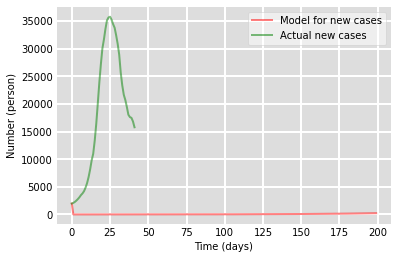

In [304]:
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t,  I, 'r', alpha=0.5, lw=2, label='Model for new cases')
ax.plot(days, xtc, 'g', alpha=0.5, lw=2, label='Actual new cases')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Number (person)')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

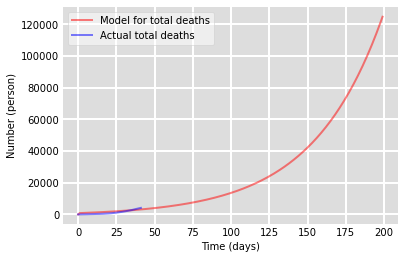

In [305]:
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t,  D, 'r', alpha=0.5, lw=2, label='Model for total deaths')
ax.plot(days, xtd, 'b', alpha=0.5, lw=2
        , label='Actual total deaths')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Number (person)')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

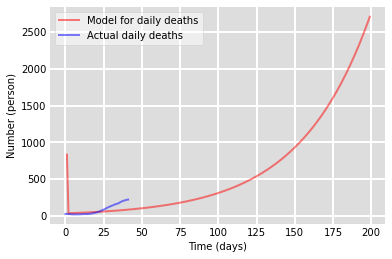

array([8.99999886e+01, 1.11198394e-02, 1.79999977e+01, 1.22551175e+01,
       5.99974351e-01, 5.00000000e+03])

In [306]:
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t[1:],  np.diff(D), 'r', alpha=0.5, lw=2, label='Model for daily deaths')
ax.plot(days, icf.loc[start_date: , 'new_deaths_smoothed'].values, 'b', alpha=0.5, lw=2, label='Actual daily deaths')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Number (person)')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()
ox

## Conclusion

The SIR model for the spread of contagious diseases is implemented. Searching for the optimized parameters of the model to fit the currently available data, it was found that there are a lot variables and options that can be investigated. Many methods were tried, but to summarize, only a simple code for model optimization is presented. 

At this stage, the model was used in a relatively simple form. People were put into 4 compartments of susceptible, infected, removed and dead. To make the model closer to the Covid-19 behavior, recovered people can lose immunity towards the virus at a certain rate. So, people may become susceptible again after infection and recovery. The number of dead people was used in the optimization process, that is why they are studied separately in this model.

The parameters of the model were considered to be fixed over time. This is not necessarily the case, even in a particular variant of the virus. Varying the parameters can be one path to continue the study. On the other hand, the variants can be seen in different places of the world at the same time. To make the model more flexible, the model can be consisted of several SIR models and the combination to be used to predict the future of the disease. 

Compared to ARIMA-based prediction models, the SIR model is much more capable to predict the maximums and minimums of the studied data. A combination of ARIMA-based models and SIR models can be a good method for predictions.